In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import tarfile 
import scipy.io
import cv2

%matplotlib inline 

# Preprocessing images

### Example

In [79]:
im = cv2.imread('../data/Images/n02086240-Shih-Tzu/n02086240_1011.jpg', cv2.IMREAD_GRAYSCALE)

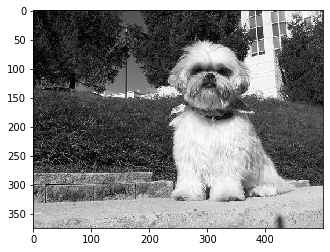

In [80]:
plt.imshow(im, cmap='gray')
plt.show()

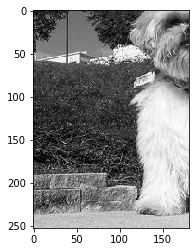

In [81]:
im = im[90:343, 121:302]
plt.imshow(im, cmap='gray')
plt.show()

In [82]:
im.shape[:2]

(253, 181)

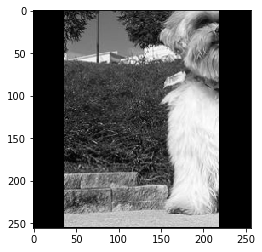

In [83]:
desired_size = 256

old_size = im.shape[:2] # old_size is in (height, width) format

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

# new_size should be in (width, height) format

im = cv2.resize(im, (new_size[1], new_size[0]))

delta_w = desired_size - new_size[1]
delta_h = desired_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
plt.imshow(new_im, cmap='gray')
plt.show()

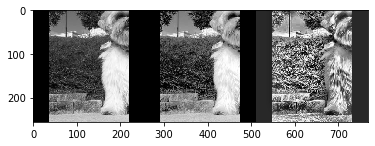

In [84]:
equ = cv2.equalizeHist(new_im)
clahe = cv2.createCLAHE()
cl1 = clahe.apply(new_im)
res = np.hstack((new_im,equ,cl1)) #stacking images side-by-side
plt.imshow(res, cmap='gray')
plt.show()

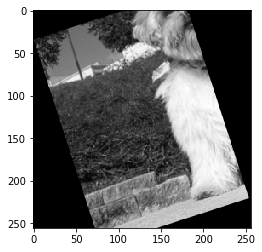

In [85]:
import random
w = new_im.shape[1]
h = new_im.shape[0]
angle = random.randint(-45,45)
M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale=1)
img_rot = cv2.warpAffine(new_im, M, (w,h))

plt.imshow(img_rot, cmap='gray')
plt.show()

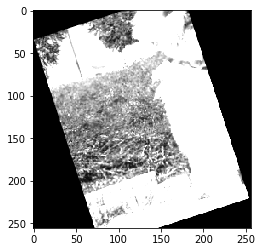

In [86]:
alpha = 2.2
beta = 50
new_image = cv2.convertScaleAbs(img_rot, alpha=alpha, beta=beta)
plt.imshow(new_image, cmap='gray')
plt.show()

In [87]:
new_image

array([[50, 50, 50, ..., 50, 50, 50],
       [50, 50, 50, ..., 50, 50, 50],
       [50, 50, 50, ..., 50, 50, 50],
       ...,
       [50, 50, 50, ..., 50, 50, 50],
       [50, 50, 50, ..., 50, 50, 50],
       [50, 50, 50, ..., 50, 50, 50]], dtype=uint8)

In [88]:
sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
kp, desc = sift.detectAndCompute(img_rot, None)
print(desc)
print(type(desc))
print(desc.shape)

[[  0.   1.   0. ...   0.   0.   3.]
 [  0.   0.   0. ... 121.  17.   3.]
 [ 21.   7.  32. ...  21.  34.  40.]
 ...
 [ 73.  47.  24. ...   0.   0.   0.]
 [  0.   0.   0. ...  39.  18.   0.]
 [  0.   0.   0. ...  56.   8.   0.]]
<class 'numpy.ndarray'>
(482, 128)


### Croping  

In [7]:
desired_size = 256

def resize(img):
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    img = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_img


clahe = cv2.createCLAHE()

In [3]:
img_path = '../data/Images/'
for r, d, f in os.walk(img_path):
    dirs = r.split(os.path.sep)[-1]
    processed_path = os.path.join('../data', 'Processed', dirs) 
    os.mkdir(processed_path)

NameError: name 'os' is not defined

In [ ]:
import os
from lxml import etree
import random

#path of annotations
img_path = '../data/Images/'

#browsing all files in Images
df = pd.DataFrame(columns=['Image', 'Breed'])

sift = cv2.xfeatures2d.SIFT_create()


for r, d, f in os.walk(img_path):
    for file in f:
        print(file)
        ###Annotation information
        
        #associated annotation path
        path = os.path.join(r, file)[15:-4]
        annotation = os.path.join('../data', 'Annotation', path)
        
        tree = etree.parse(annotation)
        #dictionnary of coordinates to crop the image to the dog part
        for x in tree.xpath('./object/bndbox'):
            l = x.getchildren()
            dim = {'xmin':int(l[0].text), 'ymin':int(l[1].text), 
                   'xmax':int(l[2].text), 'ymax':int(l[3].text)}
        #breed 
        for x in tree.xpath('./object/name'):
            breed = x.text
        
        ###Cropping and resizing

        image = cv2.imread(os.path.join(r, file), cv2.IMREAD_GRAYSCALE)
        
        #get dimension 
        xmin = dim['xmin']
        xmax = dim['xmax']
        ymin = dim['ymin']
        ymax = dim['ymax']
        #cropping
        img_crop = image[ymin:ymax, xmin:xmax]
        #resizing
        img_resize = resize(img_crop)
        #add to dataframe
        
        # kp is the keypoints
        #
        # desc is the SIFT descriptors, they're 128-dimensional vectors
        # that we can use for our final features
        kp, desc = sift.detectAndCompute(img_resize, None)
        df = df.append({'Image': desc, 'Breed': breed}, ignore_index=True)
        #saving
        img = img_resize.copy()
        new_path = os.path.join('../data','Processed',path +'.jpg')
        cv2.imwrite(new_path, img)
        
        ###Data augmentation
        
        #rotation
        w = img.shape[1]
        h = img.shape[0]
        angle = random.randint(-45,45)
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale=1)
        img_rot = cv2.warpAffine(image, M, (w,h))
        img_rot = img_rot.copy()
        new_path = os.path.join('../data','Processed',path +'_rot.jpg')
        cv2.imwrite(new_path, img_rot)
        kp, desc = sift.detectAndCompute(img_rot, None)
        df = df.append({'Image': desc, 'Breed': breed}, ignore_index=True)
        
        #contrast
        img_contrast = clahe.apply(img)
        img_contrast = img_contrast.copy()
        new_path = os.path.join('../data','Processed',path +'_contrast.jpg')
        cv2.imwrite(new_path, img_contrast)
        kp, desc = sift.detectAndCompute(img_contrast, None)
        df = df.append({'Image': desc, 'Breed': breed}, ignore_index=True)
        
        #contrast bis
        alpha = random.randint(1,3)
        beta = random.randint(0,100)
        img_contrast2 = cv2.convertScaleAbs(img_rot, alpha=alpha, beta=beta)
        img_contrast2 = img_contrast2.copy()
        new_path = os.path.join('../data','Processed',path +'_rdm_contrast.jpg')
        cv2.imwrite(new_path, img_contrast2)
        kp, desc = sift.detectAndCompute(img_contrast2, None)
        df = df.append({'Image': desc, 'Breed': breed}, ignore_index=True)
        

n02085620_10074.jpg
n02085620_10131.jpg
n02085620_10621.jpg
n02085620_1073.jpg
n02085620_10976.jpg
n02085620_11140.jpg
n02085620_11238.jpg
n02085620_11258.jpg
n02085620_11337.jpg
n02085620_11477.jpg
n02085620_1152.jpg
n02085620_11696.jpg
n02085620_11818.jpg
n02085620_11948.jpg
n02085620_1205.jpg
n02085620_12101.jpg
n02085620_12334.jpg
n02085620_1235.jpg
n02085620_1271.jpg
n02085620_12718.jpg
n02085620_1298.jpg
n02085620_13151.jpg
n02085620_1321.jpg
n02085620_13383.jpg
n02085620_1346.jpg
n02085620_13964.jpg
n02085620_14252.jpg
n02085620_14413.jpg
n02085620_14516.jpg
n02085620_1455.jpg
n02085620_1492.jpg
n02085620_1502.jpg
n02085620_1558.jpg
n02085620_1569.jpg
n02085620_1617.jpg
n02085620_1620.jpg
n02085620_1765.jpg
n02085620_1816.jpg
n02085620_1862.jpg
n02085620_1916.jpg
n02085620_199.jpg
n02085620_2053.jpg
n02085620_2188.jpg
n02085620_2204.jpg
n02085620_2208.jpg
n02085620_242.jpg
n02085620_2479.jpg
n02085620_2507.jpg
n02085620_2517.jpg
n02085620_2590.jpg
n02085620_2614.jpg
n02085620_26

n02085936_3217.jpg
n02085936_3239.jpg
n02085936_3292.jpg
n02085936_3313.jpg
n02085936_3315.jpg
n02085936_3326.jpg
n02085936_3348.jpg
n02085936_338.jpg
n02085936_3391.jpg
n02085936_3394.jpg
n02085936_3396.jpg
n02085936_3451.jpg
n02085936_3470.jpg
n02085936_352.jpg
n02085936_3580.jpg
n02085936_3677.jpg
n02085936_3678.jpg
n02085936_3698.jpg
n02085936_37.jpg
n02085936_3863.jpg
n02085936_3947.jpg
n02085936_3994.jpg
n02085936_4004.jpg
n02085936_4070.jpg
n02085936_4188.jpg
n02085936_4192.jpg
n02085936_420.jpg
n02085936_4245.jpg
n02085936_4257.jpg
n02085936_426.jpg
n02085936_4262.jpg
n02085936_4271.jpg
n02085936_4318.jpg
n02085936_4343.jpg
n02085936_4351.jpg
n02085936_4396.jpg
n02085936_4474.jpg
n02085936_4480.jpg
n02085936_4490.jpg
n02085936_4506.jpg
n02085936_4569.jpg
n02085936_4608.jpg
n02085936_461.jpg
n02085936_4695.jpg
n02085936_4713.jpg
n02085936_4781.jpg
n02085936_4797.jpg
n02085936_4894.jpg
n02085936_4897.jpg
n02085936_4916.jpg
n02085936_4921.jpg
n02085936_4924.jpg
n02085936_4929.jpg


n02086240_533.jpg
n02086240_5352.jpg
n02086240_5443.jpg
n02086240_5520.jpg
n02086240_5536.jpg
n02086240_5541.jpg
n02086240_5546.jpg
n02086240_5554.jpg
n02086240_5627.jpg
n02086240_5696.jpg
n02086240_5703.jpg
n02086240_574.jpg
n02086240_5889.jpg
n02086240_5957.jpg
n02086240_5976.jpg
n02086240_599.jpg
n02086240_5994.jpg
n02086240_6032.jpg
n02086240_6082.jpg
n02086240_61.jpg
n02086240_6106.jpg
n02086240_6116.jpg
n02086240_6131.jpg
n02086240_6222.jpg
n02086240_6269.jpg
n02086240_6322.jpg
n02086240_6323.jpg
n02086240_646.jpg
n02086240_6463.jpg
n02086240_6477.jpg
n02086240_6585.jpg
n02086240_6587.jpg
n02086240_6606.jpg
n02086240_6647.jpg
n02086240_6795.jpg
n02086240_6819.jpg
n02086240_6833.jpg
n02086240_6849.jpg
n02086240_6871.jpg
n02086240_6882.jpg
n02086240_6898.jpg
n02086240_6911.jpg
n02086240_6924.jpg
n02086240_6992.jpg
n02086240_707.jpg
n02086240_7079.jpg
n02086240_7093.jpg
n02086240_7100.jpg
n02086240_7110.jpg
n02086240_7123.jpg
n02086240_7142.jpg
n02086240_7170.jpg
n02086240_7195.jpg


n02086910_7909.jpg
n02086910_7949.jpg
n02086910_797.jpg
n02086910_7998.jpg
n02086910_7999.jpg
n02086910_8047.jpg
n02086910_8091.jpg
n02086910_8120.jpg
n02086910_8194.jpg
n02086910_8209.jpg
n02086910_8241.jpg
n02086910_8342.jpg
n02086910_8354.jpg
n02086910_847.jpg
n02086910_8573.jpg
n02086910_8590.jpg
n02086910_8606.jpg
n02086910_8613.jpg
n02086910_862.jpg
n02086910_865.jpg
n02086910_881.jpg
n02086910_8866.jpg
n02086910_8872.jpg
n02086910_9000.jpg
n02086910_9041.jpg
n02086910_9056.jpg
n02086910_9084.jpg
n02086910_9128.jpg
n02086910_9296.jpg
n02086910_9317.jpg
n02086910_933.jpg
n02086910_9355.jpg
n02086910_9408.jpg
n02086910_9527.jpg
n02086910_9579.jpg
n02086910_9710.jpg
n02086910_984.jpg
n02086910_9883.jpg
n02087046_1004.jpg
n02087046_1206.jpg
n02087046_133.jpg
n02087046_1386.jpg
n02087046_1468.jpg
n02087046_1482.jpg
n02087046_1520.jpg
n02087046_1577.jpg
n02087046_1658.jpg
n02087046_1666.jpg
n02087046_1703.jpg
n02087046_1724.jpg
n02087046_178.jpg
n02087046_1792.jpg
n02087046_1989.jpg
n0

n02088094_1475.jpg
n02088094_1479.jpg
n02088094_1534.jpg
n02088094_1592.jpg
n02088094_1611.jpg
n02088094_1618.jpg
n02088094_1661.jpg
n02088094_1724.jpg
n02088094_173.jpg
n02088094_1823.jpg
n02088094_1829.jpg
n02088094_1841.jpg
n02088094_185.jpg
n02088094_1882.jpg
n02088094_1907.jpg
n02088094_1917.jpg
n02088094_1924.jpg
n02088094_1932.jpg
n02088094_2062.jpg
n02088094_2131.jpg
n02088094_2173.jpg
n02088094_227.jpg
n02088094_2292.jpg
n02088094_231.jpg
n02088094_2458.jpg
n02088094_251.jpg
n02088094_2522.jpg
n02088094_2545.jpg
n02088094_2559.jpg
n02088094_26.jpg
n02088094_2626.jpg
n02088094_2641.jpg
n02088094_266.jpg
n02088094_2700.jpg
n02088094_272.jpg
n02088094_2726.jpg
n02088094_2732.jpg
n02088094_2738.jpg
n02088094_2798.jpg
n02088094_2803.jpg
n02088094_2822.jpg
n02088094_2879.jpg
n02088094_294.jpg
n02088094_305.jpg
n02088094_3051.jpg
n02088094_3057.jpg
n02088094_3059.jpg
n02088094_3075.jpg
n02088094_3080.jpg
n02088094_3119.jpg
n02088094_3159.jpg
n02088094_3201.jpg
n02088094_3233.jpg
n020

n02088364_13981.jpg
n02088364_14055.jpg
n02088364_14079.jpg
n02088364_14095.jpg
n02088364_14220.jpg
n02088364_14369.jpg
n02088364_14394.jpg
n02088364_14431.jpg
n02088364_14548.jpg
n02088364_14613.jpg
n02088364_14663.jpg
n02088364_14690.jpg
n02088364_14702.jpg
n02088364_14779.jpg
n02088364_14863.jpg
n02088364_14892.jpg
n02088364_14911.jpg
n02088364_14968.jpg
n02088364_15036.jpg
n02088364_1507.jpg
n02088364_15082.jpg
n02088364_15093.jpg
n02088364_15111.jpg
n02088364_15305.jpg
n02088364_15315.jpg
n02088364_15370.jpg
n02088364_15690.jpg
n02088364_15787.jpg
n02088364_15877.jpg
n02088364_16060.jpg
n02088364_16065.jpg
n02088364_161.jpg
n02088364_16165.jpg
n02088364_16207.jpg
n02088364_16210.jpg
n02088364_16339.jpg
n02088364_16493.jpg
n02088364_16502.jpg
n02088364_16508.jpg
n02088364_16519.jpg
n02088364_16588.jpg
n02088364_16635.jpg
n02088364_16689.jpg
n02088364_16695.jpg
n02088364_16704.jpg
n02088364_16721.jpg
n02088364_16791.jpg
n02088364_16881.jpg
n02088364_16985.jpg
n02088364_17167.jpg
n02

n02088632_3993.jpg
n02088632_4002.jpg
n02088632_401.jpg
n02088632_4024.jpg
n02088632_403.jpg
n02088632_4052.jpg
n02088632_4058.jpg
n02088632_4109.jpg
n02088632_4144.jpg
n02088632_4157.jpg
n02088632_4160.jpg
n02088632_4188.jpg
n02088632_419.jpg
n02088632_4208.jpg
n02088632_4210.jpg
n02088632_4250.jpg
n02088632_4305.jpg
n02088632_4309.jpg
n02088632_4313.jpg
n02088632_4332.jpg
n02088632_4334.jpg
n02088632_4339.jpg
n02088632_4360.jpg
n02088632_4389.jpg
n02088632_4414.jpg
n02088632_4431.jpg
n02088632_4491.jpg
n02088632_4584.jpg
n02088632_4590.jpg
n02088632_4613.jpg
n02088632_4625.jpg
n02088632_4633.jpg
n02088632_4647.jpg
n02088632_4648.jpg
n02088632_4686.jpg
n02088632_4687.jpg
n02088632_512.jpg
n02088632_562.jpg
n02088632_597.jpg
n02088632_600.jpg
n02088632_610.jpg
n02088632_613.jpg
n02088632_616.jpg
n02088632_650.jpg
n02088632_679.jpg
n02088632_686.jpg
n02088632_70.jpg
n02088632_725.jpg
n02088632_744.jpg
n02088632_747.jpg
n02088632_793.jpg
n02088632_813.jpg
n02088632_819.jpg
n02088632_834.

n02089973_2415.jpg
n02089973_243.jpg
n02089973_2457.jpg
n02089973_2476.jpg
n02089973_2484.jpg
n02089973_2497.jpg
n02089973_2500.jpg
n02089973_2509.jpg
n02089973_251.jpg
n02089973_255.jpg
n02089973_2551.jpg
n02089973_2599.jpg
n02089973_2603.jpg
n02089973_2608.jpg
n02089973_263.jpg
n02089973_2633.jpg
n02089973_2681.jpg
n02089973_270.jpg
n02089973_2716.jpg
n02089973_2756.jpg
n02089973_2781.jpg
n02089973_2791.jpg
n02089973_2810.jpg
n02089973_289.jpg
n02089973_2905.jpg
n02089973_2943.jpg
n02089973_3037.jpg
n02089973_3040.jpg
n02089973_3055.jpg
n02089973_3074.jpg
n02089973_3089.jpg
n02089973_3113.jpg
n02089973_3119.jpg
n02089973_3120.jpg
n02089973_3136.jpg
n02089973_3147.jpg
n02089973_3156.jpg
n02089973_3159.jpg
n02089973_3160.jpg
n02089973_319.jpg
n02089973_32.jpg
n02089973_3243.jpg
n02089973_3265.jpg
n02089973_3299.jpg
n02089973_3307.jpg
n02089973_3323.jpg
n02089973_3401.jpg
n02089973_3420.jpg
n02089973_3426.jpg
n02089973_3433.jpg
n02089973_3454.jpg
n02089973_3480.jpg
n02089973_3604.jpg
n0

n02090721_1918.jpg
n02090721_1920.jpg
n02090721_1931.jpg
n02090721_195.jpg
n02090721_1954.jpg
n02090721_1979.jpg
n02090721_1981.jpg
n02090721_2021.jpg
n02090721_2047.jpg
n02090721_2068.jpg
n02090721_2083.jpg
n02090721_209.jpg
n02090721_2101.jpg
n02090721_2116.jpg
n02090721_2131.jpg
n02090721_2143.jpg
n02090721_2170.jpg
n02090721_2179.jpg
n02090721_220.jpg
n02090721_2235.jpg
n02090721_2254.jpg
n02090721_2267.jpg
n02090721_2270.jpg
n02090721_2299.jpg
n02090721_2305.jpg
n02090721_2319.jpg
n02090721_2340.jpg
n02090721_2347.jpg
n02090721_2351.jpg
n02090721_2361.jpg
n02090721_2366.jpg
n02090721_2442.jpg
n02090721_2461.jpg
n02090721_2474.jpg
n02090721_2536.jpg
n02090721_2540.jpg
n02090721_2550.jpg
n02090721_2552.jpg
n02090721_2651.jpg
n02090721_2702.jpg
n02090721_272.jpg
n02090721_2725.jpg
n02090721_2731.jpg
n02090721_2800.jpg
n02090721_2836.jpg
n02090721_2860.jpg
n02090721_2934.jpg
n02090721_2945.jpg
n02090721_296.jpg
n02090721_2964.jpg
n02090721_2967.jpg
n02090721_3034.jpg
n02090721_309.jpg

n02091134_15827.jpg
n02091134_15846.jpg
n02091134_15865.jpg
n02091134_15876.jpg
n02091134_15938.jpg
n02091134_16005.jpg
n02091134_16033.jpg
n02091134_16062.jpg
n02091134_16086.jpg
n02091134_16109.jpg
n02091134_16200.jpg
n02091134_16201.jpg
n02091134_16336.jpg
n02091134_16337.jpg
n02091134_16420.jpg
n02091134_16541.jpg
n02091134_16794.jpg
n02091134_16890.jpg
n02091134_16904.jpg
n02091134_17054.jpg
n02091134_17108.jpg
n02091134_17394.jpg
n02091134_17467.jpg
n02091134_17567.jpg
n02091134_17608.jpg
n02091134_17638.jpg
n02091134_17675.jpg
n02091134_17788.jpg
n02091134_17872.jpg
n02091134_17950.jpg
n02091134_18069.jpg
n02091134_18140.jpg
n02091134_18392.jpg
n02091134_18403.jpg
n02091134_18435.jpg
n02091134_18472.jpg
n02091134_18590.jpg
n02091134_18824.jpg
n02091134_18902.jpg
n02091134_18905.jpg
n02091134_18951.jpg
n02091134_19084.jpg
n02091134_19124.jpg
n02091134_19129.jpg
n02091134_19166.jpg
n02091134_19204.jpg
n02091134_19308.jpg
n02091134_19354.jpg
n02091134_20065.jpg
n02091134_2193.jpg
n

n02091467_5184.jpg
n02091467_5239.jpg
n02091467_5349.jpg
n02091467_5359.jpg
n02091467_5367.jpg
n02091467_5450.jpg
n02091467_5474.jpg
n02091467_5490.jpg
n02091467_5592.jpg
n02091467_5629.jpg
n02091467_5640.jpg
n02091467_5654.jpg
n02091467_5755.jpg
n02091467_5786.jpg
n02091467_5879.jpg
n02091467_5955.jpg
n02091467_5985.jpg
n02091467_6103.jpg
n02091467_6235.jpg
n02091467_6240.jpg
n02091467_627.jpg
n02091467_6295.jpg
n02091467_6372.jpg
n02091467_6457.jpg
n02091467_6459.jpg
n02091467_6508.jpg
n02091467_6558.jpg
n02091467_6670.jpg
n02091467_6680.jpg
n02091467_6726.jpg
n02091467_6770.jpg
n02091467_6820.jpg
n02091467_6920.jpg
n02091467_6955.jpg
n02091467_6962.jpg
n02091467_7068.jpg
n02091467_7070.jpg
n02091467_708.jpg
n02091467_7085.jpg
n02091467_7095.jpg
n02091467_7151.jpg
n02091467_7265.jpg
n02091467_7281.jpg
n02091467_7291.jpg
n02091467_73.jpg
n02091467_7315.jpg
n02091467_7351.jpg
n02091467_7363.jpg
n02091467_7405.jpg
n02091467_7407.jpg
n02091467_7416.jpg
n02091467_7432.jpg
n02091467_7433.j

n02092002_12414.jpg
n02092002_1242.jpg
n02092002_1253.jpg
n02092002_12544.jpg
n02092002_12595.jpg
n02092002_12828.jpg
n02092002_12977.jpg
n02092002_13159.jpg
n02092002_13372.jpg
n02092002_13380.jpg
n02092002_1339.jpg
n02092002_13565.jpg
n02092002_14102.jpg
n02092002_14315.jpg
n02092002_14369.jpg
n02092002_1438.jpg
n02092002_1439.jpg
n02092002_1451.jpg
n02092002_14540.jpg
n02092002_14567.jpg
n02092002_14771.jpg
n02092002_14825.jpg
n02092002_14858.jpg
n02092002_149.jpg
n02092002_14917.jpg
n02092002_15010.jpg
n02092002_15064.jpg
n02092002_15096.jpg
n02092002_15112.jpg
n02092002_15165.jpg
n02092002_15198.jpg
n02092002_15215.jpg
n02092002_15342.jpg
n02092002_15354.jpg
n02092002_1551.jpg
n02092002_1564.jpg
n02092002_1583.jpg
n02092002_1592.jpg
n02092002_1601.jpg
n02092002_1608.jpg
n02092002_1646.jpg
n02092002_1693.jpg
n02092002_1698.jpg
n02092002_1727.jpg
n02092002_1730.jpg
n02092002_1767.jpg
n02092002_1828.jpg
n02092002_1890.jpg
n02092002_1937.jpg
n02092002_1962.jpg
n02092002_198.jpg
n02092

n02093256_3297.jpg
n02093256_3306.jpg
n02093256_3323.jpg
n02093256_3325.jpg
n02093256_3353.jpg
n02093256_3378.jpg
n02093256_3462.jpg
n02093256_3529.jpg
n02093256_3582.jpg
n02093256_3595.jpg
n02093256_3614.jpg
n02093256_367.jpg
n02093256_3762.jpg
n02093256_3799.jpg
n02093256_3812.jpg
n02093256_3872.jpg
n02093256_3877.jpg
n02093256_3906.jpg
n02093256_3941.jpg
n02093256_3994.jpg
n02093256_4007.jpg
n02093256_4022.jpg
n02093256_4036.jpg
n02093256_4058.jpg
n02093256_4090.jpg
n02093256_417.jpg
n02093256_4245.jpg
n02093256_4263.jpg
n02093256_4374.jpg
n02093256_4452.jpg
n02093256_4658.jpg
n02093256_4678.jpg
n02093256_4874.jpg
n02093256_4888.jpg
n02093256_4972.jpg
n02093256_4997.jpg
n02093256_5007.jpg
n02093256_5110.jpg
n02093256_5134.jpg
n02093256_5139.jpg
n02093256_5295.jpg
n02093256_5325.jpg
n02093256_5327.jpg
n02093256_540.jpg
n02093256_5428.jpg
n02093256_5439.jpg
n02093256_5600.jpg
n02093256_5646.jpg
n02093256_5647.jpg
n02093256_5654.jpg
n02093256_567.jpg
n02093256_5711.jpg
n02093256_5733.j

n02093647_930.jpg
n02093647_933.jpg
n02093647_981.jpg
n02093647_99.jpg
n02093754_1062.jpg
n02093754_1100.jpg
n02093754_1102.jpg
n02093754_1111.jpg
n02093754_1148.jpg
n02093754_115.jpg
n02093754_123.jpg
n02093754_1247.jpg
n02093754_1256.jpg
n02093754_1283.jpg
n02093754_1310.jpg
n02093754_1329.jpg
n02093754_1422.jpg
n02093754_1460.jpg
n02093754_1464.jpg
n02093754_1536.jpg
n02093754_1557.jpg
n02093754_1652.jpg
n02093754_1722.jpg
n02093754_175.jpg
n02093754_180.jpg
n02093754_1833.jpg
n02093754_1845.jpg
n02093754_186.jpg
n02093754_1861.jpg
n02093754_1895.jpg
n02093754_1954.jpg
n02093754_2123.jpg
n02093754_218.jpg
n02093754_2189.jpg
n02093754_2207.jpg
n02093754_2276.jpg
n02093754_2281.jpg
n02093754_234.jpg
n02093754_2425.jpg
n02093754_2453.jpg
n02093754_2457.jpg
n02093754_2687.jpg
n02093754_2742.jpg
n02093754_2799.jpg
n02093754_2801.jpg
n02093754_2847.jpg
n02093754_2887.jpg
n02093754_2959.jpg
n02093754_3113.jpg
n02093754_3152.jpg
n02093754_3176.jpg
n02093754_329.jpg
n02093754_3339.jpg
n02093

n02093991_3314.jpg
n02093991_3330.jpg
n02093991_3339.jpg
n02093991_3383.jpg
n02093991_3403.jpg
n02093991_3424.jpg
n02093991_3453.jpg
n02093991_3464.jpg
n02093991_3516.jpg
n02093991_3536.jpg
n02093991_3603.jpg
n02093991_3604.jpg
n02093991_3623.jpg
n02093991_3653.jpg
n02093991_3673.jpg
n02093991_3695.jpg
n02093991_373.jpg
n02093991_3735.jpg
n02093991_3783.jpg
n02093991_3807.jpg
n02093991_3812.jpg
n02093991_3824.jpg
n02093991_3830.jpg
n02093991_3838.jpg
n02093991_3905.jpg
n02093991_3918.jpg
n02093991_3935.jpg
n02093991_3952.jpg
n02093991_3968.jpg
n02093991_403.jpg
n02093991_4052.jpg
n02093991_4140.jpg
n02093991_4147.jpg
n02093991_4151.jpg
n02093991_4169.jpg
n02093991_4171.jpg
n02093991_4282.jpg
n02093991_4287.jpg
n02093991_4306.jpg
n02093991_434.jpg
n02093991_4356.jpg
n02093991_4396.jpg
n02093991_4404.jpg
n02093991_4441.jpg
n02093991_4449.jpg
n02093991_4462.jpg
n02093991_4482.jpg
n02093991_4490.jpg
n02093991_4501.jpg
n02093991_4506.jpg
n02093991_4515.jpg
n02093991_4524.jpg
n02093991_4589.

n02094258_95.jpg
n02094258_969.jpg
n02094258_977.jpg
n02094258_990.jpg
n02094258_992.jpg
n02094433_10123.jpg
n02094433_10126.jpg
n02094433_10184.jpg
n02094433_1030.jpg
n02094433_1177.jpg
n02094433_1210.jpg
n02094433_1211.jpg
n02094433_1219.jpg
n02094433_126.jpg
n02094433_1269.jpg
n02094433_1301.jpg
n02094433_1312.jpg
n02094433_1324.jpg
n02094433_1376.jpg
n02094433_1483.jpg
n02094433_1490.jpg
n02094433_1525.jpg
n02094433_1539.jpg
n02094433_1634.jpg
n02094433_1765.jpg
n02094433_1770.jpg
n02094433_1772.jpg
n02094433_1824.jpg
n02094433_1849.jpg
n02094433_1868.jpg
n02094433_1869.jpg
n02094433_194.jpg
n02094433_199.jpg
n02094433_2006.jpg
n02094433_2022.jpg
n02094433_2041.jpg
n02094433_2053.jpg
n02094433_2105.jpg
n02094433_2114.jpg
n02094433_2115.jpg
n02094433_2125.jpg
n02094433_2127.jpg
n02094433_2197.jpg
n02094433_2223.jpg
n02094433_2229.jpg
n02094433_225.jpg
n02094433_2266.jpg
n02094433_2328.jpg
n02094433_2340.jpg
n02094433_2349.jpg
n02094433_2375.jpg
n02094433_2401.jpg
n02094433_2417.jpg


n02095570_4171.jpg
n02095570_4183.jpg
n02095570_4188.jpg
n02095570_4226.jpg
n02095570_4237.jpg
n02095570_4256.jpg
n02095570_4259.jpg
n02095570_427.jpg
n02095570_4279.jpg
n02095570_429.jpg
n02095570_4331.jpg
n02095570_434.jpg
n02095570_4343.jpg
n02095570_4347.jpg
n02095570_4407.jpg
n02095570_4436.jpg
n02095570_4511.jpg
n02095570_4560.jpg
n02095570_457.jpg
n02095570_4625.jpg
n02095570_4626.jpg
n02095570_4650.jpg
n02095570_4656.jpg
n02095570_471.jpg
n02095570_4724.jpg
n02095570_4762.jpg
n02095570_477.jpg
n02095570_4782.jpg
n02095570_4846.jpg
n02095570_4854.jpg
n02095570_4985.jpg
n02095570_5010.jpg
n02095570_5024.jpg
n02095570_5038.jpg
n02095570_5068.jpg
n02095570_5074.jpg
n02095570_510.jpg
n02095570_5148.jpg
n02095570_5159.jpg
n02095570_5276.jpg
n02095570_5316.jpg
n02095570_532.jpg
n02095570_5365.jpg
n02095570_539.jpg
n02095570_5404.jpg
n02095570_5484.jpg
n02095570_563.jpg
n02095570_5641.jpg
n02095570_5719.jpg
n02095570_5761.jpg
n02095570_5796.jpg
n02095570_5800.jpg
n02095570_5820.jpg
n02

n02096051_6972.jpg
n02096051_7.jpg
n02096051_7077.jpg
n02096051_7118.jpg
n02096051_7132.jpg
n02096051_7140.jpg
n02096051_738.jpg
n02096051_7394.jpg
n02096051_7463.jpg
n02096051_7516.jpg
n02096051_7580.jpg
n02096051_7602.jpg
n02096051_7647.jpg
n02096051_7677.jpg
n02096051_7762.jpg
n02096051_7772.jpg
n02096051_7790.jpg
n02096051_7847.jpg
n02096051_8019.jpg
n02096051_8096.jpg
n02096051_8103.jpg
n02096051_812.jpg
n02096051_8132.jpg
n02096051_8149.jpg
n02096051_8227.jpg
n02096051_8270.jpg
n02096051_8385.jpg
n02096051_8392.jpg
n02096051_841.jpg
n02096051_8431.jpg
n02096051_8553.jpg
n02096051_8613.jpg
n02096051_8790.jpg
n02096051_8826.jpg
n02096051_8880.jpg
n02096051_8892.jpg
n02096051_8937.jpg
n02096051_8989.jpg
n02096051_9038.jpg
n02096051_910.jpg
n02096051_9135.jpg
n02096051_93.jpg
n02096051_9319.jpg
n02096051_9327.jpg
n02096051_9329.jpg
n02096051_9359.jpg
n02096051_9388.jpg
n02096051_9391.jpg
n02096051_9427.jpg
n02096051_9440.jpg
n02096051_950.jpg
n02096051_9581.jpg
n02096051_9617.jpg
n02

n02096294_8467.jpg
n02096294_8476.jpg
n02096294_8487.jpg
n02096294_8522.jpg
n02096294_8531.jpg
n02096294_8557.jpg
n02096294_8594.jpg
n02096294_8702.jpg
n02096294_8706.jpg
n02096294_8721.jpg
n02096294_8778.jpg
n02096294_895.jpg
n02096294_987.jpg
n02096294_989.jpg
n02096437_1006.jpg
n02096437_1012.jpg
n02096437_1015.jpg
n02096437_1054.jpg
n02096437_1055.jpg
n02096437_1070.jpg
n02096437_1098.jpg
n02096437_1125.jpg
n02096437_1129.jpg
n02096437_1135.jpg
n02096437_1143.jpg
n02096437_1171.jpg
n02096437_1207.jpg
n02096437_1219.jpg
n02096437_1267.jpg
n02096437_1320.jpg
n02096437_1367.jpg
n02096437_137.jpg
n02096437_1385.jpg
n02096437_140.jpg
n02096437_1420.jpg
n02096437_1424.jpg
n02096437_1448.jpg
n02096437_1456.jpg
n02096437_148.jpg
n02096437_1503.jpg
n02096437_1511.jpg
n02096437_1521.jpg
n02096437_1532.jpg
n02096437_1551.jpg
n02096437_1605.jpg
n02096437_1613.jpg
n02096437_1614.jpg
n02096437_1641.jpg
n02096437_1643.jpg
n02096437_1650.jpg
n02096437_1653.jpg
n02096437_1656.jpg
n02096437_1668.jpg

n02097047_2439.jpg
n02097047_2463.jpg
n02097047_2466.jpg
n02097047_2470.jpg
n02097047_2472.jpg
n02097047_2487.jpg
n02097047_2497.jpg
n02097047_2511.jpg
n02097047_255.jpg
n02097047_2551.jpg
n02097047_2565.jpg
n02097047_2589.jpg
n02097047_2596.jpg
n02097047_2604.jpg
n02097047_2605.jpg
n02097047_263.jpg
n02097047_2634.jpg
n02097047_2649.jpg
n02097047_2663.jpg
n02097047_2701.jpg
n02097047_271.jpg
n02097047_2769.jpg
n02097047_2776.jpg
n02097047_2865.jpg
n02097047_2871.jpg
n02097047_2910.jpg
n02097047_2917.jpg
n02097047_2937.jpg
n02097047_2984.jpg
n02097047_3035.jpg
n02097047_3074.jpg
n02097047_3093.jpg
n02097047_3103.jpg
n02097047_3233.jpg
n02097047_328.jpg
n02097047_3429.jpg
n02097047_3458.jpg
n02097047_35.jpg
n02097047_3534.jpg
n02097047_3579.jpg
n02097047_37.jpg
n02097047_3978.jpg
n02097047_4018.jpg
n02097047_4274.jpg
n02097047_4400.jpg
n02097047_4440.jpg
n02097047_4443.jpg
n02097047_4563.jpg
n02097047_4634.jpg
n02097047_4644.jpg
n02097047_4844.jpg
n02097047_4929.jpg
n02097047_5030.jpg
n

n02097298_2132.jpg
n02097298_2135.jpg
n02097298_2184.jpg
n02097298_2227.jpg
n02097298_2279.jpg
n02097298_2287.jpg
n02097298_231.jpg
n02097298_2420.jpg
n02097298_2443.jpg
n02097298_2468.jpg
n02097298_2492.jpg
n02097298_2500.jpg
n02097298_256.jpg
n02097298_2583.jpg
n02097298_2609.jpg
n02097298_2671.jpg
n02097298_2722.jpg
n02097298_2792.jpg
n02097298_2863.jpg
n02097298_2868.jpg
n02097298_2957.jpg
n02097298_2976.jpg
n02097298_2998.jpg
n02097298_3238.jpg
n02097298_3301.jpg
n02097298_3342.jpg
n02097298_344.jpg
n02097298_3483.jpg
n02097298_3516.jpg
n02097298_3521.jpg
n02097298_3522.jpg
n02097298_3579.jpg
n02097298_3589.jpg
n02097298_3611.jpg
n02097298_3618.jpg
n02097298_3641.jpg
n02097298_378.jpg
n02097298_3780.jpg
n02097298_39.jpg
n02097298_3968.jpg
n02097298_4020.jpg
n02097298_4092.jpg
n02097298_4126.jpg
n02097298_4162.jpg
n02097298_432.jpg
n02097298_4485.jpg
n02097298_4565.jpg
n02097298_4628.jpg
n02097298_4640.jpg
n02097298_4701.jpg
n02097298_4872.jpg
n02097298_4882.jpg
n02097298_4909.jpg


n02097658_4231.jpg
n02097658_427.jpg
n02097658_4363.jpg
n02097658_4402.jpg
n02097658_4420.jpg
n02097658_46.jpg
n02097658_4728.jpg
n02097658_4778.jpg
n02097658_4869.jpg
n02097658_4890.jpg
n02097658_4952.jpg
n02097658_4992.jpg
n02097658_5223.jpg
n02097658_5273.jpg
n02097658_5420.jpg
n02097658_552.jpg
n02097658_5535.jpg
n02097658_5548.jpg
n02097658_5643.jpg
n02097658_5728.jpg
n02097658_595.jpg
n02097658_6.jpg
n02097658_6014.jpg
n02097658_6017.jpg
n02097658_6044.jpg
n02097658_611.jpg
n02097658_6202.jpg
n02097658_6289.jpg
n02097658_6300.jpg
n02097658_633.jpg
n02097658_6351.jpg
n02097658_6357.jpg
n02097658_641.jpg
n02097658_642.jpg
n02097658_646.jpg
n02097658_6546.jpg
n02097658_6605.jpg
n02097658_6672.jpg
n02097658_6678.jpg
n02097658_6726.jpg
n02097658_6784.jpg
n02097658_6867.jpg
n02097658_7162.jpg
n02097658_727.jpg
n02097658_7425.jpg
n02097658_7445.jpg
n02097658_7474.jpg
n02097658_758.jpg
n02097658_7619.jpg
n02097658_7785.jpg
n02097658_7893.jpg
n02097658_7970.jpg
n02097658_8018.jpg
n0209765

n02098413_14748.jpg
n02098413_14785.jpg
n02098413_1480.jpg
n02098413_1492.jpg
n02098413_14953.jpg
n02098413_1522.jpg
n02098413_1552.jpg
n02098413_15855.jpg
n02098413_16009.jpg
n02098413_16076.jpg
n02098413_161.jpg
n02098413_16322.jpg
n02098413_1655.jpg
n02098413_1668.jpg
n02098413_16861.jpg
n02098413_1693.jpg
n02098413_1702.jpg
n02098413_1713.jpg
n02098413_1718.jpg
n02098413_1719.jpg
n02098413_17364.jpg
n02098413_17369.jpg
n02098413_17759.jpg
n02098413_178.jpg
n02098413_1784.jpg
n02098413_17895.jpg
n02098413_17946.jpg
n02098413_18307.jpg
n02098413_18317.jpg
n02098413_18548.jpg
n02098413_18647.jpg
n02098413_18663.jpg
n02098413_18706.jpg
n02098413_19649.jpg
n02098413_20034.jpg
n02098413_20304.jpg
n02098413_20356.jpg
n02098413_20398.jpg
n02098413_2047.jpg
n02098413_20499.jpg
n02098413_20614.jpg
n02098413_20657.jpg
n02098413_20677.jpg
n02098413_20774.jpg
n02098413_20830.jpg
n02098413_21040.jpg
n02098413_21411.jpg
n02098413_2169.jpg
n02098413_2199.jpg
n02098413_2308.jpg
n02098413_2400.jpg
n

n02099429_448.jpg
n02099429_458.jpg
n02099429_537.jpg
n02099429_569.jpg
n02099429_583.jpg
n02099429_618.jpg
n02099429_630.jpg
n02099429_664.jpg
n02099429_674.jpg
n02099429_68.jpg
n02099429_708.jpg
n02099429_738.jpg
n02099429_745.jpg
n02099429_814.jpg
n02099429_817.jpg
n02099429_833.jpg
n02099429_841.jpg
n02099429_853.jpg
n02099429_869.jpg
n02099429_878.jpg
n02099429_896.jpg
n02099429_907.jpg
n02099429_910.jpg
n02099429_915.jpg
n02099429_935.jpg
n02099429_946.jpg
n02099429_961.jpg
n02099601_10.jpg
n02099601_100.jpg
n02099601_1010.jpg
n02099601_1028.jpg
n02099601_109.jpg
n02099601_1162.jpg
n02099601_118.jpg
n02099601_124.jpg
n02099601_1249.jpg
n02099601_1259.jpg
n02099601_1324.jpg
n02099601_14.jpg
n02099601_142.jpg
n02099601_1442.jpg
n02099601_1454.jpg
n02099601_146.jpg
n02099601_1580.jpg
n02099601_1633.jpg
n02099601_1743.jpg
n02099601_176.jpg
n02099601_1768.jpg
n02099601_2029.jpg
n02099601_2076.jpg
n02099601_215.jpg
n02099601_2295.jpg
n02099601_2358.jpg
n02099601_2359.jpg
n02099601_238.

n02099849_3383.jpg
n02099849_3403.jpg
n02099849_3429.jpg
n02099849_3451.jpg
n02099849_3494.jpg
n02099849_3563.jpg
n02099849_3565.jpg
n02099849_3592.jpg
n02099849_3616.jpg
n02099849_3617.jpg
n02099849_3619.jpg
n02099849_3645.jpg
n02099849_3680.jpg
n02099849_3718.jpg
n02099849_3723.jpg
n02099849_3736.jpg
n02099849_3753.jpg
n02099849_3777.jpg
n02099849_3789.jpg
n02099849_3810.jpg
n02099849_3812.jpg
n02099849_3826.jpg
n02099849_3881.jpg
n02099849_3897.jpg
n02099849_3911.jpg
n02099849_3940.jpg
n02099849_3976.jpg
n02099849_410.jpg
n02099849_4113.jpg
n02099849_415.jpg
n02099849_4180.jpg
n02099849_4215.jpg
n02099849_4278.jpg
n02099849_4287.jpg
n02099849_43.jpg
n02099849_4310.jpg
n02099849_4322.jpg
n02099849_4348.jpg
n02099849_435.jpg
n02099849_4406.jpg
n02099849_4413.jpg
n02099849_4419.jpg
n02099849_4457.jpg
n02099849_448.jpg
n02099849_4498.jpg
n02099849_4519.jpg
n02099849_4549.jpg
n02099849_4619.jpg
n02099849_463.jpg
n02099849_4636.jpg
n02099849_4646.jpg
n02099849_4667.jpg
n02099849_4677.jpg


n02100735_3583.jpg
n02100735_3595.jpg
n02100735_3599.jpg
n02100735_3709.jpg
n02100735_3777.jpg
n02100735_3847.jpg
n02100735_3899.jpg
n02100735_3923.jpg
n02100735_3942.jpg
n02100735_3998.jpg
n02100735_4.jpg
n02100735_4035.jpg
n02100735_4040.jpg
n02100735_4051.jpg
n02100735_4057.jpg
n02100735_4079.jpg
n02100735_4172.jpg
n02100735_4195.jpg
n02100735_4208.jpg
n02100735_4333.jpg
n02100735_4508.jpg
n02100735_4531.jpg
n02100735_4540.jpg
n02100735_4544.jpg
n02100735_4706.jpg
n02100735_4735.jpg
n02100735_4813.jpg
n02100735_4857.jpg
n02100735_4870.jpg
n02100735_4875.jpg
n02100735_4912.jpg
n02100735_4943.jpg
n02100735_4949.jpg
n02100735_4972.jpg
n02100735_5010.jpg
n02100735_5024.jpg
n02100735_5054.jpg
n02100735_5207.jpg
n02100735_523.jpg
n02100735_5234.jpg
n02100735_5258.jpg
n02100735_5265.jpg
n02100735_5353.jpg
n02100735_5435.jpg
n02100735_5649.jpg
n02100735_568.jpg
n02100735_5713.jpg
n02100735_5821.jpg
n02100735_5852.jpg
n02100735_5876.jpg
n02100735_5967.jpg
n02100735_5978.jpg
n02100735_5988.jp

n02101388_1262.jpg
n02101388_1445.jpg
n02101388_1456.jpg
n02101388_149.jpg
n02101388_1517.jpg
n02101388_1524.jpg
n02101388_1803.jpg
n02101388_183.jpg
n02101388_1842.jpg
n02101388_190.jpg
n02101388_192.jpg
n02101388_1941.jpg
n02101388_1965.jpg
n02101388_197.jpg
n02101388_2021.jpg
n02101388_2064.jpg
n02101388_2076.jpg
n02101388_2142.jpg
n02101388_2159.jpg
n02101388_2171.jpg
n02101388_2177.jpg
n02101388_2324.jpg
n02101388_2429.jpg
n02101388_2522.jpg
n02101388_2529.jpg
n02101388_2565.jpg
n02101388_2597.jpg
n02101388_2645.jpg
n02101388_2667.jpg
n02101388_2671.jpg
n02101388_2689.jpg
n02101388_2737.jpg
n02101388_2773.jpg
n02101388_2833.jpg
n02101388_2862.jpg
n02101388_2888.jpg
n02101388_2889.jpg
n02101388_2970.jpg
n02101388_2999.jpg
n02101388_3003.jpg
n02101388_3023.jpg
n02101388_3036.jpg
n02101388_3064.jpg
n02101388_3098.jpg
n02101388_3195.jpg
n02101388_3280.jpg
n02101388_3294.jpg
n02101388_3320.jpg
n02101388_3344.jpg
n02101388_3357.jpg
n02101388_3365.jpg
n02101388_3416.jpg
n02101388_348.jpg

n02102040_835.jpg
n02102040_841.jpg
n02102040_8463.jpg
n02102040_858.jpg
n02102040_876.jpg
n02102040_902.jpg
n02102040_95.jpg
n02102040_97.jpg
n02102040_986.jpg
n02102040_988.jpg
n02102040_995.jpg
n02102177_1022.jpg
n02102177_1028.jpg
n02102177_1039.jpg
n02102177_1055.jpg
n02102177_108.jpg
n02102177_1128.jpg
n02102177_1160.jpg
n02102177_1175.jpg
n02102177_1187.jpg
n02102177_1210.jpg
n02102177_1241.jpg
n02102177_1242.jpg
n02102177_1257.jpg
n02102177_1361.jpg
n02102177_1386.jpg
n02102177_1423.jpg
n02102177_1471.jpg
n02102177_1472.jpg
n02102177_1476.jpg
n02102177_1509.jpg
n02102177_1520.jpg
n02102177_1546.jpg
n02102177_1567.jpg
n02102177_1643.jpg
n02102177_1681.jpg
n02102177_1702.jpg
n02102177_1707.jpg
n02102177_1760.jpg
n02102177_1763.jpg
n02102177_1798.jpg
n02102177_1833.jpg
n02102177_1874.jpg
n02102177_1914.jpg
n02102177_1922.jpg
n02102177_1980.jpg
n02102177_1998.jpg
n02102177_1999.jpg
n02102177_2001.jpg
n02102177_2010.jpg
n02102177_2018.jpg
n02102177_2054.jpg
n02102177_2055.jpg
n02102

n02102480_6651.jpg
n02102480_6780.jpg
n02102480_6842.jpg
n02102480_6922.jpg
n02102480_6995.jpg
n02102480_6998.jpg
n02102480_7025.jpg
n02102480_7126.jpg
n02102480_7189.jpg
n02102480_7212.jpg
n02102480_7238.jpg
n02102480_7313.jpg
n02102480_7371.jpg
n02102480_7417.jpg
n02102480_7449.jpg
n02102480_7472.jpg
n02102480_7580.jpg
n02102480_7591.jpg
n02102480_7625.jpg
n02102480_7629.jpg
n02102480_7641.jpg
n02102480_7676.jpg
n02102480_7690.jpg
n02102480_7723.jpg
n02102480_7831.jpg
n02102480_7850.jpg
n02102480_7854.jpg
n02102480_7929.jpg
n02102480_7981.jpg
n02102480_8002.jpg
n02102480_8030.jpg
n02102480_8081.jpg
n02102480_8117.jpg
n02102480_8187.jpg
n02102480_8240.jpg
n02102480_8269.jpg
n02102480_8279.jpg
n02102480_842.jpg
n02102973_1037.jpg
n02102973_1066.jpg
n02102973_1116.jpg
n02102973_1140.jpg
n02102973_1142.jpg
n02102973_1200.jpg
n02102973_1254.jpg
n02102973_1270.jpg
n02102973_1299.jpg
n02102973_1318.jpg
n02102973_1377.jpg
n02102973_1409.jpg
n02102973_158.jpg
n02102973_1609.jpg
n02102973_1615

n02104365_7641.jpg
n02104365_7643.jpg
n02104365_7768.jpg
n02104365_7791.jpg
n02104365_7822.jpg
n02104365_7859.jpg
n02104365_7881.jpg
n02104365_7887.jpg
n02104365_7892.jpg
n02104365_7906.jpg
n02104365_7927.jpg
n02104365_7944.jpg
n02104365_7953.jpg
n02104365_7956.jpg
n02104365_8119.jpg
n02104365_8156.jpg
n02104365_8161.jpg
n02104365_8190.jpg
n02104365_8226.jpg
n02104365_8334.jpg
n02104365_8398.jpg
n02104365_8451.jpg
n02104365_8466.jpg
n02104365_8525.jpg
n02104365_8548.jpg
n02104365_8630.jpg
n02104365_8701.jpg
n02104365_8706.jpg
n02104365_8769.jpg
n02104365_8919.jpg
n02104365_8998.jpg
n02104365_9004.jpg
n02104365_9041.jpg
n02104365_9131.jpg
n02104365_9143.jpg
n02104365_9238.jpg
n02104365_9248.jpg
n02104365_9255.jpg
n02104365_9309.jpg
n02104365_9337.jpg
n02104365_9354.jpg
n02104365_9369.jpg
n02104365_9399.jpg
n02104365_9489.jpg
n02104365_9552.jpg
n02104365_9595.jpg
n02104365_9611.jpg
n02104365_9639.jpg
n02104365_9640.jpg
n02104365_9712.jpg
n02104365_9873.jpg
n02104365_9916.jpg
n02104365_99

n02105251_6984.jpg
n02105251_6995.jpg
n02105251_7044.jpg
n02105251_7056.jpg
n02105251_7058.jpg
n02105251_7086.jpg
n02105251_7090.jpg
n02105251_7115.jpg
n02105251_7127.jpg
n02105251_7170.jpg
n02105251_7171.jpg
n02105251_7178.jpg
n02105251_7207.jpg
n02105251_7223.jpg
n02105251_7233.jpg
n02105251_7294.jpg
n02105251_7348.jpg
n02105251_7349.jpg
n02105251_7356.jpg
n02105251_7430.jpg
n02105251_7434.jpg
n02105251_7579.jpg
n02105251_7593.jpg
n02105251_7600.jpg
n02105251_7627.jpg
n02105251_7647.jpg
n02105251_7654.jpg
n02105251_7666.jpg
n02105251_7723.jpg
n02105251_7738.jpg
n02105251_7745.jpg
n02105251_7750.jpg
n02105251_7772.jpg
n02105251_7797.jpg
n02105251_7805.jpg
n02105251_7816.jpg
n02105251_7950.jpg
n02105251_7977.jpg
n02105251_7996.jpg
n02105251_8027.jpg
n02105251_8075.jpg
n02105251_8078.jpg
n02105251_8082.jpg
n02105251_8094.jpg
n02105251_8161.jpg
n02105251_8194.jpg
n02105251_8210.jpg
n02105251_8229.jpg
n02105251_8240.jpg
n02105251_8296.jpg
n02105251_8345.jpg
n02105251_8384.jpg
n02105251_85

n02105641_1921.jpg
n02105641_1966.jpg
n02105641_2018.jpg
n02105641_2052.jpg
n02105641_2120.jpg
n02105641_2138.jpg
n02105641_24.jpg
n02105641_2586.jpg
n02105641_2606.jpg
n02105641_2607.jpg
n02105641_2750.jpg
n02105641_277.jpg
n02105641_2822.jpg
n02105641_285.jpg
n02105641_2905.jpg
n02105641_2918.jpg
n02105641_309.jpg
n02105641_313.jpg
n02105641_3317.jpg
n02105641_3331.jpg
n02105641_3364.jpg
n02105641_3499.jpg
n02105641_3531.jpg
n02105641_3540.jpg
n02105641_3543.jpg
n02105641_3585.jpg
n02105641_3602.jpg
n02105641_3723.jpg
n02105641_3724.jpg
n02105641_3800.jpg
n02105641_4150.jpg
n02105641_4268.jpg
n02105641_4443.jpg
n02105641_4577.jpg
n02105641_4594.jpg
n02105641_4660.jpg
n02105641_4677.jpg
n02105641_4733.jpg
n02105641_4751.jpg
n02105641_4796.jpg
n02105641_4805.jpg
n02105641_4833.jpg
n02105641_4975.jpg
n02105641_4997.jpg
n02105641_5017.jpg
n02105641_5049.jpg
n02105641_5057.jpg
n02105641_523.jpg
n02105641_5305.jpg
n02105641_534.jpg
n02105641_5341.jpg
n02105641_5577.jpg
n02105641_5776.jpg
n

n02106030_9078.jpg
n02106030_9153.jpg
n02106030_9339.jpg
n02106030_9354.jpg
n02106030_9815.jpg
n02106030_991.jpg
n02106166_1031.jpg
n02106166_1032.jpg
n02106166_1055.jpg
n02106166_1056.jpg
n02106166_1059.jpg
n02106166_1128.jpg
n02106166_1133.jpg
n02106166_117.jpg
n02106166_1204.jpg
n02106166_1205.jpg
n02106166_1236.jpg
n02106166_1244.jpg
n02106166_1246.jpg
n02106166_1284.jpg
n02106166_1311.jpg
n02106166_135.jpg
n02106166_1426.jpg
n02106166_1429.jpg
n02106166_1452.jpg
n02106166_1460.jpg
n02106166_1506.jpg
n02106166_152.jpg
n02106166_1539.jpg
n02106166_1637.jpg
n02106166_1663.jpg
n02106166_1674.jpg
n02106166_1684.jpg
n02106166_1705.jpg
n02106166_1729.jpg
n02106166_1754.jpg
n02106166_1776.jpg
n02106166_1796.jpg
n02106166_18.jpg
n02106166_180.jpg
n02106166_1822.jpg
n02106166_1842.jpg
n02106166_1845.jpg
n02106166_1854.jpg
n02106166_1874.jpg
n02106166_1936.jpg
n02106166_1975.jpg
n02106166_1983.jpg
n02106166_1990.jpg
n02106166_2000.jpg
n02106166_2006.jpg
n02106166_204.jpg
n02106166_2043.jpg
n

n02106550_7473.jpg
n02106550_7608.jpg
n02106550_7616.jpg
n02106550_7767.jpg
n02106550_8024.jpg
n02106550_8064.jpg
n02106550_8116.jpg
n02106550_8146.jpg
n02106550_8166.jpg
n02106550_8383.jpg
n02106550_8437.jpg
n02106550_8595.jpg
n02106550_8611.jpg
n02106550_8652.jpg
n02106550_8776.jpg
n02106550_8887.jpg
n02106550_895.jpg
n02106550_8994.jpg
n02106550_9084.jpg
n02106550_9317.jpg
n02106550_9348.jpg
n02106550_9432.jpg
n02106550_9508.jpg
n02106550_982.jpg
n02106662_10122.jpg
n02106662_10338.jpg
n02106662_104.jpg
n02106662_10490.jpg
n02106662_10552.jpg
n02106662_10676.jpg
n02106662_10715.jpg
n02106662_10858.jpg
n02106662_1094.jpg
n02106662_11620.jpg
n02106662_11808.jpg
n02106662_12028.jpg
n02106662_12116.jpg
n02106662_12906.jpg
n02106662_12969.jpg
n02106662_13050.jpg
n02106662_13123.jpg
n02106662_13178.jpg
n02106662_13368.jpg
n02106662_13380.jpg
n02106662_13599.jpg
n02106662_13904.jpg
n02106662_13912.jpg
n02106662_14247.jpg
n02106662_1451.jpg
n02106662_146.jpg
n02106662_14842.jpg
n02106662_14

n02107312_5290.jpg
n02107312_5299.jpg
n02107312_5357.jpg
n02107312_5385.jpg
n02107312_5407.jpg
n02107312_5431.jpg
n02107312_5452.jpg
n02107312_546.jpg
n02107312_5474.jpg
n02107312_5567.jpg
n02107312_5599.jpg
n02107312_5604.jpg
n02107312_5625.jpg
n02107312_5665.jpg
n02107312_5686.jpg
n02107312_5719.jpg
n02107312_5752.jpg
n02107312_5776.jpg
n02107312_579.jpg
n02107312_5792.jpg
n02107312_5798.jpg
n02107312_5816.jpg
n02107312_5862.jpg
n02107312_5968.jpg
n02107312_5987.jpg
n02107312_6003.jpg
n02107312_6029.jpg
n02107312_6049.jpg
n02107312_6051.jpg
n02107312_6080.jpg
n02107312_6098.jpg
n02107312_612.jpg
n02107312_6129.jpg
n02107312_6136.jpg
n02107312_6151.jpg
n02107312_6186.jpg
n02107312_6246.jpg
n02107312_6275.jpg
n02107312_6375.jpg
n02107312_6380.jpg
n02107312_6487.jpg
n02107312_6541.jpg
n02107312_6580.jpg
n02107312_6598.jpg
n02107312_6617.jpg
n02107312_6650.jpg
n02107312_6680.jpg
n02107312_6683.jpg
n02107312_6695.jpg
n02107312_67.jpg
n02107312_6706.jpg
n02107312_6823.jpg
n02107312_6924.jp

n02107683_6336.jpg
n02107683_6378.jpg
n02107683_6381.jpg
n02107683_6580.jpg
n02107683_6596.jpg
n02107683_6660.jpg
n02107683_673.jpg
n02107683_6752.jpg
n02107683_6772.jpg
n02107683_6781.jpg
n02107683_6800.jpg
n02107683_6825.jpg
n02107683_6846.jpg
n02107683_6875.jpg
n02107683_690.jpg
n02107683_6916.jpg
n02107683_6950.jpg
n02107683_697.jpg
n02107683_698.jpg
n02107683_6998.jpg
n02107683_6999.jpg
n02107683_7038.jpg
n02107683_705.jpg
n02107683_71.jpg
n02107683_7104.jpg
n02107683_7183.jpg
n02107683_7196.jpg
n02107683_7202.jpg
n02107683_735.jpg
n02107683_825.jpg
n02107683_906.jpg
n02107683_997.jpg
n02107908_1030.jpg
n02107908_1176.jpg
n02107908_1195.jpg
n02107908_1235.jpg
n02107908_1344.jpg
n02107908_1426.jpg
n02107908_1575.jpg
n02107908_1777.jpg
n02107908_1783.jpg
n02107908_180.jpg
n02107908_1811.jpg
n02107908_1855.jpg
n02107908_1974.jpg
n02107908_2085.jpg
n02107908_2090.jpg
n02107908_2092.jpg
n02107908_2134.jpg
n02107908_2151.jpg
n02107908_2154.jpg
n02107908_2227.jpg
n02107908_2272.jpg
n0210

n02108089_1675.jpg
n02108089_1690.jpg
n02108089_1748.jpg
n02108089_1757.jpg
n02108089_1775.jpg
n02108089_1859.jpg
n02108089_1912.jpg
n02108089_1956.jpg
n02108089_200.jpg
n02108089_2007.jpg
n02108089_2056.jpg
n02108089_2106.jpg
n02108089_2355.jpg
n02108089_2360.jpg
n02108089_2367.jpg
n02108089_2432.jpg
n02108089_2482.jpg
n02108089_2526.jpg
n02108089_2608.jpg
n02108089_2653.jpg
n02108089_2670.jpg
n02108089_268.jpg
n02108089_2718.jpg
n02108089_2723.jpg
n02108089_2740.jpg
n02108089_2741.jpg
n02108089_2791.jpg
n02108089_2796.jpg
n02108089_2815.jpg
n02108089_2831.jpg
n02108089_2917.jpg
n02108089_2953.jpg
n02108089_3028.jpg
n02108089_3162.jpg
n02108089_3236.jpg
n02108089_3248.jpg
n02108089_3258.jpg
n02108089_3269.jpg
n02108089_3365.jpg
n02108089_3395.jpg
n02108089_3400.jpg
n02108089_3412.jpg
n02108089_3547.jpg
n02108089_3557.jpg
n02108089_3669.jpg
n02108089_3899.jpg
n02108089_395.jpg
n02108089_4002.jpg
n02108089_4042.jpg
n02108089_4076.jpg
n02108089_4119.jpg
n02108089_4158.jpg
n02108089_4440.

n02108915_1839.jpg
n02108915_1866.jpg
n02108915_1871.jpg
n02108915_1895.jpg
n02108915_1911.jpg
n02108915_1958.jpg
n02108915_198.jpg
n02108915_2118.jpg
n02108915_2166.jpg
n02108915_225.jpg
n02108915_2279.jpg
n02108915_2307.jpg
n02108915_2312.jpg
n02108915_2326.jpg
n02108915_2380.jpg
n02108915_2391.jpg
n02108915_2514.jpg
n02108915_2545.jpg
n02108915_2570.jpg
n02108915_2603.jpg
n02108915_2681.jpg
n02108915_2756.jpg
n02108915_2807.jpg
n02108915_2835.jpg
n02108915_2899.jpg
n02108915_2926.jpg
n02108915_2946.jpg
n02108915_2980.jpg
n02108915_3083.jpg
n02108915_3098.jpg
n02108915_3104.jpg
n02108915_311.jpg
n02108915_3129.jpg
n02108915_3140.jpg
n02108915_3153.jpg
n02108915_3184.jpg
n02108915_3202.jpg
n02108915_3219.jpg
n02108915_3258.jpg
n02108915_3266.jpg
n02108915_328.jpg
n02108915_3300.jpg
n02108915_3346.jpg
n02108915_3369.jpg
n02108915_3382.jpg
n02108915_3398.jpg
n02108915_341.jpg
n02108915_3464.jpg
n02108915_350.jpg
n02108915_3520.jpg
n02108915_3527.jpg
n02108915_3544.jpg
n02108915_3557.jpg

n02109525_7024.jpg
n02109525_7085.jpg
n02109525_7109.jpg
n02109525_7121.jpg
n02109525_7336.jpg
n02109525_7444.jpg
n02109525_7497.jpg
n02109525_751.jpg
n02109525_7579.jpg
n02109525_7656.jpg
n02109525_7982.jpg
n02109525_8096.jpg
n02109525_8211.jpg
n02109525_823.jpg
n02109525_8312.jpg
n02109525_8417.jpg
n02109525_8475.jpg
n02109525_8545.jpg
n02109525_8704.jpg
n02109525_8822.jpg
n02109525_883.jpg
n02109525_9130.jpg
n02109525_9243.jpg
n02109525_9345.jpg
n02109525_9379.jpg
n02109525_9426.jpg
n02109525_950.jpg
n02109525_9522.jpg
n02109525_9869.jpg
n02109525_9872.jpg
n02109525_997.jpg
n02109961_10021.jpg
n02109961_1017.jpg
n02109961_1032.jpg
n02109961_10660.jpg
n02109961_10699.jpg
n02109961_1076.jpg
n02109961_10774.jpg
n02109961_11224.jpg
n02109961_11511.jpg
n02109961_11634.jpg
n02109961_12107.jpg
n02109961_12118.jpg
n02109961_12338.jpg
n02109961_1235.jpg
n02109961_1251.jpg
n02109961_1253.jpg
n02109961_12719.jpg
n02109961_1276.jpg
n02109961_12993.jpg
n02109961_13077.jpg
n02109961_131.jpg
n0210

n02110185_14650.jpg
n02110185_1469.jpg
n02110185_14766.jpg
n02110185_14906.jpg
n02110185_1497.jpg
n02110185_15019.jpg
n02110185_15063.jpg
n02110185_1511.jpg
n02110185_1532.jpg
n02110185_1534.jpg
n02110185_1552.jpg
n02110185_1598.jpg
n02110185_1614.jpg
n02110185_1748.jpg
n02110185_1794.jpg
n02110185_184.jpg
n02110185_2368.jpg
n02110185_2446.jpg
n02110185_248.jpg
n02110185_2593.jpg
n02110185_2604.jpg
n02110185_2614.jpg
n02110185_2672.jpg
n02110185_2701.jpg
n02110185_2728.jpg
n02110185_2736.jpg
n02110185_2820.jpg
n02110185_2941.jpg
n02110185_3039.jpg
n02110185_3291.jpg
n02110185_3302.jpg
n02110185_3328.jpg
n02110185_3406.jpg
n02110185_353.jpg
n02110185_3540.jpg
n02110185_3589.jpg
n02110185_3651.jpg
n02110185_3808.jpg
n02110185_388.jpg
n02110185_4030.jpg
n02110185_4060.jpg
n02110185_4115.jpg
n02110185_4133.jpg
n02110185_4186.jpg
n02110185_4294.jpg
n02110185_4522.jpg
n02110185_4677.jpg
n02110185_4694.jpg
n02110185_4906.jpg
n02110185_5030.jpg
n02110185_5143.jpg
n02110185_5159.jpg
n02110185_5

n02110806_4853.jpg
n02110806_487.jpg
n02110806_4876.jpg
n02110806_4888.jpg
n02110806_4966.jpg
n02110806_4994.jpg
n02110806_5051.jpg
n02110806_5114.jpg
n02110806_513.jpg
n02110806_518.jpg
n02110806_5238.jpg
n02110806_5256.jpg
n02110806_5301.jpg
n02110806_5312.jpg
n02110806_5343.jpg
n02110806_5381.jpg
n02110806_5389.jpg
n02110806_5537.jpg
n02110806_563.jpg
n02110806_5642.jpg
n02110806_5660.jpg
n02110806_5663.jpg
n02110806_5688.jpg
n02110806_5692.jpg
n02110806_5744.jpg
n02110806_581.jpg
n02110806_582.jpg
n02110806_5861.jpg
n02110806_5971.jpg
n02110806_6016.jpg
n02110806_6035.jpg
n02110806_6066.jpg
n02110806_6080.jpg
n02110806_6137.jpg
n02110806_6156.jpg
n02110806_6247.jpg
n02110806_6282.jpg
n02110806_6323.jpg
n02110806_6352.jpg
n02110806_6380.jpg
n02110806_6424.jpg
n02110806_6528.jpg
n02110806_6542.jpg
n02110806_6554.jpg
n02110806_6678.jpg
n02110806_673.jpg
n02110806_749.jpg
n02110806_757.jpg
n02110806_759.jpg
n02110806_761.jpg
n02110806_762.jpg
n02110806_839.jpg
n02110806_849.jpg
n021108

n02111129_4958.jpg
n02111129_4981.jpg
n02111129_513.jpg
n02111129_5144.jpg
n02111129_5156.jpg
n02111129_5163.jpg
n02111129_5237.jpg
n02111129_5250.jpg
n02111129_5256.jpg
n02111129_5262.jpg
n02111129_5300.jpg
n02111129_5303.jpg
n02111129_545.jpg
n02111129_547.jpg
n02111129_571.jpg
n02111129_593.jpg
n02111129_605.jpg
n02111129_638.jpg
n02111129_646.jpg
n02111129_650.jpg
n02111129_658.jpg
n02111129_686.jpg
n02111129_710.jpg
n02111129_716.jpg
n02111129_74.jpg
n02111129_754.jpg
n02111129_77.jpg
n02111129_774.jpg
n02111129_796.jpg
n02111129_819.jpg
n02111129_844.jpg
n02111129_856.jpg
n02111129_861.jpg
n02111129_892.jpg
n02111129_970.jpg
n02111129_974.jpg
n02111129_976.jpg
n02111129_990.jpg
n02111277_1008.jpg
n02111277_10160.jpg
n02111277_1018.jpg
n02111277_1023.jpg
n02111277_10237.jpg
n02111277_1029.jpg
n02111277_10333.jpg
n02111277_1040.jpg
n02111277_10573.jpg
n02111277_10578.jpg
n02111277_10769.jpg
n02111277_110.jpg
n02111277_11106.jpg
n02111277_11433.jpg
n02111277_11530.jpg
n02111277_1177

n02111500_9003.jpg
n02111500_9015.jpg
n02111500_9018.jpg
n02111500_9116.jpg
n02111500_9250.jpg
n02111500_9264.jpg
n02111500_9298.jpg
n02111500_9306.jpg
n02111500_9420.jpg
n02111500_9423.jpg
n02111500_956.jpg
n02111889_1.jpg
n02111889_10059.jpg
n02111889_10084.jpg
n02111889_1019.jpg
n02111889_1020.jpg
n02111889_10206.jpg
n02111889_10324.jpg
n02111889_10734.jpg
n02111889_108.jpg
n02111889_10950.jpg
n02111889_10987.jpg
n02111889_1145.jpg
n02111889_11502.jpg
n02111889_11729.jpg
n02111889_12037.jpg
n02111889_12045.jpg
n02111889_12073.jpg
n02111889_12171.jpg
n02111889_12529.jpg
n02111889_1255.jpg
n02111889_1264.jpg
n02111889_12771.jpg
n02111889_12811.jpg
n02111889_12976.jpg
n02111889_1314.jpg
n02111889_13281.jpg
n02111889_1340.jpg
n02111889_13603.jpg
n02111889_1363.jpg
n02111889_13657.jpg
n02111889_13737.jpg
n02111889_1374.jpg
n02111889_13772.jpg
n02111889_13924.jpg
n02111889_1402.jpg
n02111889_14064.jpg
n02111889_1421.jpg
n02111889_1438.jpg
n02111889_14413.jpg
n02111889_1444.jpg
n02111889_1

n02112018_863.jpg
n02112018_869.jpg
n02112018_8745.jpg
n02112018_877.jpg
n02112018_883.jpg
n02112018_888.jpg
n02112018_9028.jpg
n02112018_904.jpg
n02112018_919.jpg
n02112018_9263.jpg
n02112018_9376.jpg
n02112018_938.jpg
n02112018_9753.jpg
n02112018_9791.jpg
n02112018_9861.jpg
n02112018_9926.jpg
n02112137_1005.jpg
n02112137_10134.jpg
n02112137_1015.jpg
n02112137_10176.jpg
n02112137_10430.jpg
n02112137_10457.jpg
n02112137_10605.jpg
n02112137_10654.jpg
n02112137_10677.jpg
n02112137_10731.jpg
n02112137_10762.jpg
n02112137_10792.jpg
n02112137_10815.jpg
n02112137_112.jpg
n02112137_11261.jpg
n02112137_11273.jpg
n02112137_11472.jpg
n02112137_11536.jpg
n02112137_11549.jpg
n02112137_11550.jpg
n02112137_11732.jpg
n02112137_11830.jpg
n02112137_11858.jpg
n02112137_11927.jpg
n02112137_11938.jpg
n02112137_1251.jpg
n02112137_12579.jpg
n02112137_12594.jpg
n02112137_126.jpg
n02112137_12685.jpg
n02112137_12741.jpg
n02112137_12766.jpg
n02112137_12792.jpg
n02112137_12819.jpg
n02112137_13075.jpg
n02112137_1

n02112706_1833.jpg
n02112706_1860.jpg
n02112706_1862.jpg
n02112706_1869.jpg
n02112706_1875.jpg
n02112706_1882.jpg
n02112706_1899.jpg
n02112706_1922.jpg
n02112706_1925.jpg
n02112706_1970.jpg
n02112706_1971.jpg
n02112706_1983.jpg
n02112706_1995.jpg
n02112706_2027.jpg
n02112706_204.jpg
n02112706_2042.jpg
n02112706_2070.jpg
n02112706_2074.jpg
n02112706_2087.jpg
n02112706_2123.jpg
n02112706_2133.jpg
n02112706_2137.jpg
n02112706_2149.jpg
n02112706_2155.jpg
n02112706_2156.jpg
n02112706_2161.jpg
n02112706_2169.jpg
n02112706_2184.jpg
n02112706_2188.jpg
n02112706_2191.jpg
n02112706_220.jpg
n02112706_223.jpg
n02112706_2269.jpg
n02112706_2295.jpg
n02112706_231.jpg
n02112706_235.jpg
n02112706_237.jpg
n02112706_2390.jpg
n02112706_2391.jpg
n02112706_2441.jpg
n02112706_2448.jpg
n02112706_2456.jpg
n02112706_2467.jpg
n02112706_2550.jpg
n02112706_256.jpg
n02112706_277.jpg
n02112706_286.jpg
n02112706_292.jpg
n02112706_31.jpg
n02112706_346.jpg
n02112706_350.jpg
n02112706_360.jpg
n02112706_362.jpg
n02112706

n02113624_1050.jpg
n02113624_1063.jpg
n02113624_1077.jpg
n02113624_1178.jpg
n02113624_1220.jpg
n02113624_1293.jpg
n02113624_1302.jpg
n02113624_1461.jpg
n02113624_1559.jpg
n02113624_1576.jpg
n02113624_1582.jpg
n02113624_1596.jpg
n02113624_1606.jpg
n02113624_1639.jpg
n02113624_166.jpg
n02113624_1756.jpg
n02113624_1785.jpg
n02113624_1801.jpg
n02113624_1804.jpg
n02113624_1832.jpg
n02113624_1844.jpg
n02113624_1879.jpg
n02113624_189.jpg
n02113624_1929.jpg
n02113624_2019.jpg
n02113624_213.jpg
n02113624_2223.jpg
n02113624_2224.jpg
n02113624_223.jpg
n02113624_2240.jpg
n02113624_2242.jpg
n02113624_2244.jpg
n02113624_2258.jpg
n02113624_2270.jpg
n02113624_2305.jpg
n02113624_2308.jpg
n02113624_2311.jpg
n02113624_239.jpg
n02113624_2427.jpg
n02113624_2508.jpg
n02113624_2521.jpg
n02113624_253.jpg
n02113624_2595.jpg
n02113624_2609.jpg
n02113624_2639.jpg
n02113624_265.jpg
n02113624_2727.jpg
n02113624_274.jpg
n02113624_2784.jpg
n02113624_2785.jpg
n02113624_2816.jpg
n02113624_288.jpg
n02113624_2883.jpg
n0

n02113799_6730.jpg
n02113799_6740.jpg
n02113799_6819.jpg
n02113799_6891.jpg
n02113799_6984.jpg
n02113799_7092.jpg
n02113799_7121.jpg
n02113799_7130.jpg
n02113799_7258.jpg
n02113799_7299.jpg
n02113799_7438.jpg
n02113799_7448.jpg
n02113799_7649.jpg
n02113799_7726.jpg
n02113799_801.jpg
n02113799_815.jpg
n02113799_848.jpg
n02113799_871.jpg
n02113799_895.jpg
n02113799_911.jpg
n02113799_923.jpg
n02113799_936.jpg
n02113799_961.jpg
n02113799_963.jpg
n02113799_983.jpg
n02113978_1006.jpg
n02113978_1030.jpg
n02113978_1034.jpg
n02113978_1069.jpg
n02113978_1088.jpg
n02113978_118.jpg
n02113978_1189.jpg
n02113978_1238.jpg
n02113978_124.jpg
n02113978_131.jpg
n02113978_1317.jpg
n02113978_1323.jpg
n02113978_1325.jpg
n02113978_1349.jpg
n02113978_1391.jpg
n02113978_143.jpg
n02113978_147.jpg
n02113978_1478.jpg
n02113978_1480.jpg
n02113978_1482.jpg
n02113978_153.jpg
n02113978_1535.jpg
n02113978_1551.jpg
n02113978_1595.jpg
n02113978_1620.jpg
n02113978_1632.jpg
n02113978_1653.jpg
n02113978_1746.jpg
n02113978_

n02115913_3878.jpg
n02115913_3902.jpg
n02115913_3918.jpg
n02115913_3991.jpg
n02115913_3994.jpg
n02115913_3998.jpg
n02115913_4025.jpg
n02115913_4031.jpg
n02115913_4032.jpg
n02115913_4047.jpg
n02115913_4055.jpg
n02115913_4059.jpg
n02115913_4082.jpg
n02115913_4110.jpg
n02115913_4117.jpg
n02115913_4119.jpg
n02115913_4128.jpg
n02115913_4129.jpg
n02115913_4144.jpg
n02115913_4163.jpg
n02115913_4179.jpg
n02115913_4188.jpg
n02115913_423.jpg
n02115913_4266.jpg
n02115913_4273.jpg
n02115913_4275.jpg
n02115913_4308.jpg
n02115913_4313.jpg
n02115913_4320.jpg
n02115913_4336.jpg
n02115913_44.jpg
n02115913_4429.jpg
n02115913_4542.jpg
n02115913_520.jpg
n02115913_539.jpg
n02115913_5392.jpg
n02115913_5418.jpg
n02115913_5469.jpg
n02115913_5507.jpg
n02115913_5593.jpg
n02115913_564.jpg
n02115913_593.jpg
n02115913_612.jpg
n02115913_614.jpg
n02115913_676.jpg
n02115913_678.jpg
n02115913_739.jpg
n02115913_750.jpg
n02115913_90.jpg
n02115913_907.jpg
n02115913_915.jpg
n02115913_92.jpg
n02116738_10024.jpg
n02116738_1

# Feature extraction

In [11]:
df

,Image,Breed
0,"[[19.0, 10.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 16...",Chihuahua
1,"[[1.0, 1.0, 11.0, 14.0, 1.0, 1.0, 4.0, 1.0, 47...",Chihuahua
2,"[[39.0, 17.0, 0.0, 0.0, 0.0, 10.0, 40.0, 26.0,...",Chihuahua
3,"[[0.0, 0.0, 0.0, 5.0, 9.0, 0.0, 0.0, 0.0, 0.0,...",Chihuahua
4,"[[91.0, 127.0, 24.0, 1.0, 1.0, 3.0, 4.0, 25.0,...",Chihuahua
...,...,...
82315,"[[33.0, 0.0, 0.0, 0.0, 0.0, 108.0, 123.0, 38.0...",African_hunting_dog
82316,"[[39.0, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0, 28.0, 9....",African_hunting_dog
82317,"[[15.0, 70.0, 26.0, 2.0, 0.0, 0.0, 4.0, 10.0, ...",African_hunting_dog
82318,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0...",African_hunting_dog


In [66]:
path = '../data/Processed/'


sift = cv2.xfeatures2d.SIFT_create()
for image in df['Image'] :
    kp, desc = sift.detectAndCompute(image, None)
    df['desc'] = desc
desc
        


n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound
n02088238-basset
n02088364-beagle
n02088466-bloodhound
n02088632-bluetick
n02089078-black-and-tan_coonhound
n02089867-Walker_hound
n02089973-English_foxhound
n02090379-redbone
n02090622-borzoi
n02090721-Irish_wolfhound
n02091032-Italian_greyhound
n02091134-whippet
n02091244-Ibizan_hound
n02091467-Norwegian_elkhound
n02091635-otterhound
n02091831-Saluki
n02092002-Scottish_deerhound
n02092339-Weimaraner
n02093256-Staffordshire_bullterrier
n02093428-American_Staffordshire_terrier
n02093647-Bedlington_terrier
n02093754-Border_terrier
n02093859-Kerry_blue_terrier
n02093991-Irish_terrier
n02094114-Norfolk_terrier
n02094258-Norwich_terrier
n02094433-Yorkshire_terrier
n02095314-wire-haired_fox_terrier
n02095570-Lakeland_terrier
n02095889-Sealyham_terrier
n02096051-Aire